In [ ]:
# Brownian v2 and v3 in this file. v2 is just for archival purpose. Use v3 for multiprocessing.

In [245]:
import random, matplotlib.pyplot as plt, time, math, multiprocessing, concurrent.futures
import numpy as np

#plt.style.use(['science'])

def flatten(xss):
    return [x for xs in xss for x in xs]

'''
gamma,Radius_of_circle=1.677 *1e-8,10 *1e-6
sigma,drift,potential_constant,time2=1.389*1e-28,0.99*3.5*1e-15,0.84*6*1e-20,100

dt=1e-1   '''  


eta=8.9*1e-4
r_particle=1e-6  #*1e-4  #multiply to change noise
Radius_of_circle=10 *1e-6
gamma=6*np.pi*eta*r_particle
temp=300
kb=1.380659*1e-23
D0=kb*temp/gamma

dt=1e-1

norm1= 0.86625   # 2 *1e-2
norm2= 1.21681   # 150 * 1e-3

drift,potential_constant,time2=  4*norm1*1e-15,  10*norm2*kb*300 ,  1000*dt



ram0=1024
def brownian_v3(iterations):
    #gamma=1.380649*(10**(-23))*300/diffusion
    pos=np.zeros((iterations,ram0))
    cur=np.zeros((iterations,ram0))
    A=np.zeros(ram0)
    B=np.zeros(ram0)
    C=[sigma, drift, potential_constant, iterations,time2]
    intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi
    #intial_pos=1.0
    theta0=np.full(ram0,intial_pos) 
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=np.pi/2
    theta=np.full(ram0,theta0)
    theta2=np.zeros(ram0)

    T=int(time2/dt) #Total time
    std=np.sqrt(dt*sigma)
    
    prefactor=1/(gamma*Radius_of_circle)
    for n in range(iterations):
        #D=np.zeros(T)
        #D[0]=intial_pos
        
        for i in range(T):
            #D[i]=theta[0]-theta0[0]
            theta+=prefactor*(np.random.normal(0,std, ram0)+(drift-potential_constant*(-np.sin(theta))/Radius_of_circle)*dt)
        
        #theta3=theta-pjjx[np.argmin(pj2)]   ##to make min at 0
        
        shift=np.pi+np.arcsin(-Radius_of_circle*drift/potential_constant)
        #shift=0
        
        theta2=theta-shift-np.floor((theta-shift-np.pi)/(2*np.pi))*2*np.pi-2*np.pi
        
        pos[n]=theta2
        cur[n]=Radius_of_circle*(theta-theta0)/time2
        
        theta=np.full(ram0,theta0)

    pos=pos.flatten()
    cur=cur.flatten()


    return pos,cur #D

if __name__ == "__main__":
    iterations=10**2
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        start_time = time.perf_counter()
        temp = list(executor.map(brownian_v3, [10 for i in range(int(iterations/10))]))
        finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    

results = [[temp[j][i] for j in range(len(temp))] for i in range(len(temp[0]))]
pos = flatten(results[0])
cur = flatten(results[1])

print(len(pos))


Program finished in 0.6187862829538062 seconds
102400


In [248]:
drift

3.465e-15

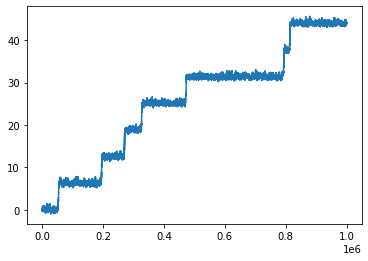

In [242]:
def brownian(sigma,drift,potential_constant,iterations,time):
    #gamma=1.380649*(10**(-23))*300/diffusion
    A=[] #Set of final positions
    B=[]
    C=[sigma, drift, potential_constant, iterations,time]
    theta0=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi 
    theta1=np.arcsin(-Radius_of_circle*drift/potential_constant)
    #use above theta0 for f<V0. For f>V0, use below theta0
    #theta0=-0.5
    theta=theta0
    
    
    K2=[]
    
    theta2=0

    T=int(time/dt) #Total time
    std=np.sqrt(dt*sigma)
    prefactor=1/(gamma*Radius_of_circle)
    for n in range(iterations):
        D=[]
        K=[]
        K0=0
        for i in range(T):
            theta+=prefactor*(random.gauss(0,std)+(drift-potential_constant*(-np.sin(theta))/Radius_of_circle)*dt)
            D.append(theta-theta0)
            #if theta0-(theta0+theta1+np.pi)/2<theta<theta1+(theta0+theta1+np.pi)/2:
            #    K0=theta
            #    K.append(K0)
            #else:
            #    break
        theta2=theta-np.floor((theta-np.pi)/(2*np.pi))*2*np.pi-2*np.pi
            
        A.append(theta2)
        B.append(Radius_of_circle*(theta-theta0)/time)
        K2.append(K)
        
        
        theta=theta0
    K2=flatten(K2)

    return A,B,C,D,K2


data=brownian(sigma,drift,potential_constant,10**0,100000)


xs = [x for x in range(len(data[3]))]

plt.plot(xs, data[3])
plt.show()

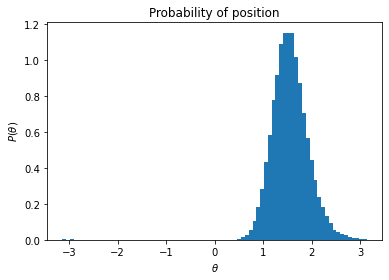

In [229]:
fig1 = plt.figure(1)
plt.hist(pos, bins=80, density=True)
plt.title('Probability of position')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta)$')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

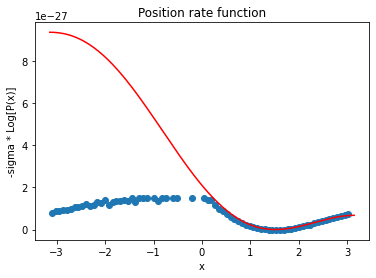

In [232]:
pj=np.histogram(pos, bins=80, density=True)[0]
pjx=np.histogram(pos, bins=80, density=True)[1]
pjj=[]
pjjx=[]
for i in range(len(pj)-1):
    if pj[i]!=0:
        pjj.append(pj[i])
        pjjx.append((pjx[i+1]+pjx[i])/2)


Area2=0
for i in range(len(pjjx)):
    Area2+=pjj[i]

Area=np.sum(pj)*(pjx[2]-pjx[1])
    
#Don't divide by area or area2. Useless


pj2=(-sigma)*np.log(pjj)

plt.scatter(pjjx,pj2)
plt.title('Position rate function')
plt.xlabel('x')
plt.ylabel('-sigma * Log[P(x)]')

intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi

shift=np.pi+np.arcsin(-Radius_of_circle*drift/potential_constant)

X = np.linspace(-np.pi, np.pi, 200)
Y= 2*1e-8*(potential_constant*np.cos(X+shift)-drift*Radius_of_circle*(X+shift)-min(potential_constant*np.cos(X+shift)-drift*Radius_of_circle*(X+shift)))

plt.plot(X, 2*Y,'r-')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

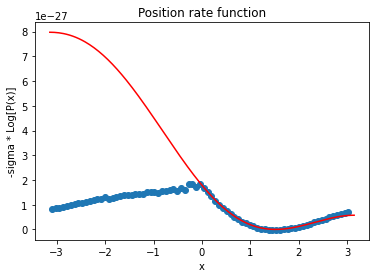

In [194]:
plt.scatter(pjjx,pj2)
plt.title('Position rate function')
plt.xlabel('x')
plt.ylabel('-sigma * Log[P(x)]')

intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi

shift=np.pi+np.arcsin(-Radius_of_circle*drift/potential_constant)

X = np.linspace(-np.pi, np.pi, 200)
Y= 1.7*1e-8*(potential_constant*np.cos(X+shift)-drift*Radius_of_circle*(X+shift)-min(potential_constant*np.cos(X+shift)-drift*Radius_of_circle*(X+shift)))

plt.plot(X, 2*Y,'r-')

plt.show

In [169]:
min(np.cos(X+shift)-drift*(X+shift))

-3.261860174599314

In [118]:
pjjx[np.argmin(pj2)]

1.8682686974947065

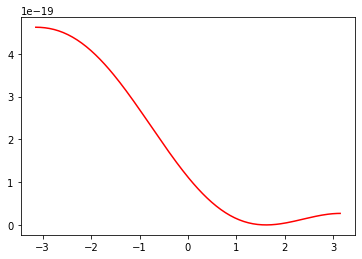

In [133]:
#intial_pos=-np.arcsin(-Radius_of_circle*drift/potential_constant)+np.pi

shift=np.pi+np.arcsin(-Radius_of_circle*drift/potential_constant)
#shift=0

X = np.linspace(-np.pi, np.pi, 200)
Y= potential_constant*np.cos(X+shift)-drift*Radius_of_circle*(X+shift)-min(potential_constant*np.cos(X+shift)-drift*Radius_of_circle*(X+shift))

plt.plot(X, 2*Y,'r-')

In [244]:
print(drift)
print(potential_constant)


3.465e-15
5.0399990333699994e-20


In [196]:
kb=1.380659*1e-23
0.84*6*1e-20/(10*kb*300)

1.2168102333740627